In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Deep Learning\\Lab 2\\MNSIT-MLPClassifer\\Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Deep Learning\\Lab 2\\MNSIT-MLPClassifer'

In [5]:
import logging
import os
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump
import arff

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

@dataclass
class DataTransformationConfig:
    root_dir: Path
    X_train_file: Path
    y_train_file: Path
    X_test_file: Path
    y_test_file: Path
    arff_data_file: Path
    scaler_file: Path

class ConfigurationManager:
    def __init__(self):
        self.root_dir = Path(os.getcwd())
        self.X_train_file = self.root_dir / "dataset/Modeltraining/X_train.csv"
        self.y_train_file = self.root_dir / "dataset/Modeltraining/y_train.csv"
        self.X_test_file = self.root_dir / "dataset/Modeltraining/X_test.csv"
        self.y_test_file = self.root_dir / "dataset/Modeltraining/y_test.csv"
        self.arff_data_file = self.root_dir / 'Dataset/Unzipped data/mnist_784.arff'
        self.scaler_file = self.root_dir / "Model/scaler.pkl"

    def get_data_transformation_config(self) -> DataTransformationConfig:
        return DataTransformationConfig(
            root_dir=self.root_dir,
            X_train_file=self.X_train_file,
            y_train_file=self.y_train_file,
            X_test_file=self.X_test_file,
            y_test_file=self.y_test_file,
            arff_data_file=self.arff_data_file,
            scaler_file=self.scaler_file
        )

class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def ensure_uniform_class_distribution(self, X, y):
        unique, counts = np.unique(y, return_counts=True)
        min_count = np.min(counts)
        avg_count = np.mean(counts)
    
        # Logging the details about class distributions
        logging.info(f"Number of unique classes in y: {len(unique)}")
        logging.info(f"Unique classes in y: {unique}")
        logging.info(f"Counts of each class in y: {counts}")
        logging.info(f"Average frequency of all classes: {avg_count}")
        logging.info(f"Minimum frequency among classes: {min_count}")
    
        X_list = []
        y_list = []
        for class_value in unique:
            class_indices = np.where(y == class_value)[0]
            np.random.shuffle(class_indices)
            selected_indices = class_indices[:min_count]
            X_list.append(X[selected_indices, :])
            y_list.append(y[selected_indices])
    
            # Logging details about data removal for balancing
            logging.info(f"Class {class_value} reduced to {min_count} instances for balancing.")
    
        X_balanced = np.concatenate(X_list, axis=0)
        y_balanced = np.concatenate(y_list, axis=0)
    
        # Shuffling the data to mix the classes
        indices = np.arange(X_balanced.shape[0])
        np.random.shuffle(indices)
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]
    
        # Logging final dataset size after balancing
        logging.info(f"Number of rows in the balanced dataset: {X_balanced.shape[0]}")
    
        return X_balanced, y_balanced

    def train_test_splitting(self):
        # Ensure the directory for the status file exists
        self.config.root_dir.mkdir(parents=True, exist_ok=True)
        
        # Load ARFF data
        with open(self.config.arff_data_file, 'r') as arff_file:
            data = arff.load(arff_file)
        logging.info("ARFF MNIST Dataset loaded")

        # Convert the loaded data to a numpy array
        data_array = np.array(data['data'], dtype=float)

        # Assuming the last column contains the target values
        X = np.array(data_array[:, :-1], dtype=np.float32)
        y = np.array(data_array[:, -1], dtype=np.float32)

        # Ensure uniform class distribution
        X_balanced, y_balanced = self.ensure_uniform_class_distribution(X, y)

        # Standardize the input data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_balanced)

        # Save the scaler in a .pkl file
        dump(scaler, self.config.scaler_file)
        logging.info(f"Scaler saved to {self.config.scaler_file}")

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_balanced, test_size=0.3, random_state=42)

        # Save the split data as CSV
        pd.DataFrame(X_train).to_csv(self.config.X_train_file, index=False)
        logging.info(f"X_train data saved to {self.config.X_train_file}")
        pd.DataFrame(y_train).to_csv(self.config.y_train_file, index=False)
        logging.info(f"y_train data saved to {self.config.y_train_file}")
        pd.DataFrame(X_test).to_csv(self.config.X_test_file, index=False)
        logging.info(f"X_test data saved to {self.config.X_test_file}")
        pd.DataFrame(y_test).to_csv(self.config.y_test_file, index=False)
        logging.info(f"y_test data saved to {self.config.y_test_file}")

def main():
    config_manager = ConfigurationManager()
    data_transformation_config = config_manager.get_data_transformation_config()
    data_transformation = DataTransformation(data_transformation_config)
    data_transformation.train_test_splitting()

if __name__ == "__main__":
    main()


2024-02-07 00:11:47,234 - INFO - ARFF MNIST Dataset loaded
2024-02-07 00:11:51,379 - INFO - Number of unique classes in y: 10
2024-02-07 00:11:51,381 - INFO - Unique classes in y: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
2024-02-07 00:11:51,384 - INFO - Counts of each class in y: [6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]
2024-02-07 00:11:51,386 - INFO - Average frequency of all classes: 7000.0
2024-02-07 00:11:51,387 - INFO - Minimum frequency among classes: 6313
2024-02-07 00:11:51,410 - INFO - Class 0.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,428 - INFO - Class 1.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,447 - INFO - Class 2.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,466 - INFO - Class 3.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,487 - INFO - Class 4.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,504 - INFO - Class 5.0 reduced to 6313 instances for balancing.
2024-02-07 00:11:51,518 - I

In [6]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = 'dataset\Modeltraining\X_train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows (by default, it shows the first 5 rows)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.03252,-0.023063,-0.016084,-0.010798,-0.007863,-0.005626,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.03252,-0.023063,-0.016084,-0.010798,-0.007863,-0.005626,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.03252,-0.023063,-0.016084,-0.010798,-0.007863,-0.005626,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.03252,-0.023063,-0.016084,-0.010798,-0.007863,-0.005626,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.03252,-0.023063,-0.016084,-0.010798,-0.007863,-0.005626,0.0,0.0,0.0,0.0


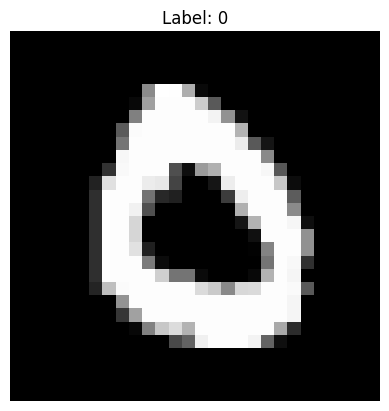

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib 

# Load the scaler
scaler_path = 'D:/Desktop/Deep Learning/Lab 2/MNSIT-MLPClassifer/Model/scaler.pkl'
scaler = joblib.load(scaler_path)

# Load the first row of the scaled dataset
csv_file_path = 'dataset/Modeltraining/X_train.csv'
df = pd.read_csv(csv_file_path, nrows=1)

# Inverse transform the scaled row to get the original image
original_image = scaler.inverse_transform(df.iloc[0].values.reshape(1, -1))

# Reshape and display the image
original_image = original_image.reshape(28, 28)

plt.imshow(original_image, cmap="gray")
plt.title("Label: 0")  # Replace with the actual label if available
plt.axis('off')
plt.show()


In [8]:
import pandas as pd

# Specify the path to your CSV file
csv_file_path = 'dataset\Modeltraining\y_train.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Display the first few rows (by default, it shows the first 5 rows)
df.head()

,0
0,0.0
1,6.0
2,7.0
3,4.0
4,0.0
